In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [2]:
%matplotlib inline

import os
import csv
import json
import pickle
import pandas as pd

import sklearn
from sklearn import model_selection
from sklearn.decomposition import PCA
import numpy as np
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import random
from random import randint
random.seed(123)
np.random.seed(123)

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import torch

# Set THEANO_FLAGS='device=cuda0,floatX=float32' to run notebook on gpu
import lasagne
from lasagne.utils import floatX
import theano
import theano.tensor as T
from collections import Counter
from lasagne.utils import floatX

import googlenet

from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 634, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 584, in pygpu.gpuarray.pygpu_init
  File "pygpu/gpuarray.pyx", line 1057, in pygpu.gpuarray.GpuContext.__cinit__
GpuArrayException: cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

# LSTM Model - Baseline

In [4]:
augmented_exams = pickle.load(open('augmented_images_baseline.pkl'))

In [5]:
augmented_images = []
for exam in augmented_exams:
    for image in exam['images']:
        item = image
        item['tokens'] = exam['tokens']
        item['split'] = exam['split']
        if 'cnn features' not in item.keys():
            print exam['patient id']
        augmented_images.append(item)

In [6]:
print random.sample(augmented_images, 1)

[{'cnn features': array([[ 0.55561978,  0.        ,  0.        , ...,  0.        ,
         0.02577852,  0.        ]], dtype=float32), 'imid': 'CR.1.3.12.2.1107.5.4.4.1104.30000015021609065289000000091', 'tokens': [u'.', u'moderately', u'severe', u'tricompartmental', u'degenerative', u'change', u'bilaterally', u'marked', u'left', u'right', u'.', u'loose', u'within', u'knee', u'joint', u'left', '.'], 'impath': 'RJ109724280/CR.1.3.12.2.1107.5.4.4.1104.30000015021609065289000000091.jpg', 'split': 'train'}]


In [7]:
d = pickle.load(open(os.path.join('aug_baseline_trained_v_167.pkl')))
vocab = d['vocab']
print len(vocab)
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']

167


In [ ]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = item['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            sentence = sentence[1:MAX_SENTENCE_LENGTH]
            #continue
        items.append((item['cnn features'], sentence, item['impath']))
    
    return items

# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1024)))
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

In [7]:
SEQUENCE_LENGTH = 33
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
#BATCH_SIZE = 50
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1024
EMBEDDING_SIZE = 256

In [8]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])


l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [9]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [10]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [77]:
# Returns a list of tuples (cnn features, list of words, exam ID)
def get_test_set(dataset):
    items = []
    for item in dataset:
        if item['split'] != 'test':
            continue
        sentence = [word for word in item['tokens'] if word in vocab]
        sentence = sentence[0:29]
        items.append((item['cnn features'], sentence, item['impath']))
    
    return items

In [78]:
test_exams = get_test_set(augmented_images)
print len(test_exams)

155


In [15]:
def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            #return ' '.join(words)
            return words
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

## BLEU Evaluation

Calculate modified ngram precision.

The normal precision method may lead to some wrong translations with high-precision, e.g., the translation, in which a word of reference repeats several times, has very high precision.

This function only returns the Fraction object that contains the numerator and denominator necessary to calculate the corpus-level precision.

In [17]:
from nltk.translate.bleu_score import modified_precision
from nltk.translate.bleu_score import sentence_bleu

RJ109686243/CR.1.2.840.113564.1018830201.20150122092847140810.1003000225002_L.jpg
Predicted: joint space narrowing seen bilaterally . . . early degenerative changes seen bilaterally joint space narrowing , lateral osteophyte formation .
 Original: . bilateral total knee replacements situ . evidence periprosthetic fracture prosthetic loosening . change since imaging taken , , .
5/21
0/20
0/19
0/18


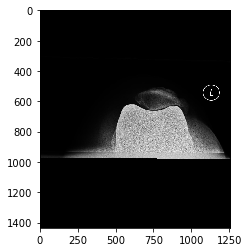

In [20]:
# Sample some predictions
for cnn_features, sentence, impath in random.sample(test_exams,1):
    prediction = predict(cnn_features)
    plt.figure()
    print impath
    im = plt.imread(dir+'data/Images/'+impath)
    plt.imshow(im)
    print "Predicted: " + ' '.join(prediction) + "\n Original: " + ' '.join(sentence)
    for n_ in range(4): 
    #weights = np.full(n+1, 1.0/(n+1))
    #print weights
        score = modified_precision([sentence], prediction, n=n_+1)
        print score

In [83]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
lmtzr = WordNetLemmatizer()

all_test_scores = []
originals = []
predictions = []
for cnn_features, sentence, impath in test_exams:
    if len(sentence) > 1:
        prediction = predict(cnn_features)
        
        #prediction_en = [word.encode('utf-8') for word in prediction]
        #sentence_en = [word.encode('utf-8') for word in sentence]
        
        predictions.append(prediction)
        originals.append(sentence)
        
        scores = []
        for n_ in range(4):
            score = modified_precision([sentence], prediction, n=n_+1)
            scores.append(float(score))
        #print 'Predicted: ', ' '.join(predictions)
        #print 'Original: ', ' '.join(sentence)
        #print 'Scores: ', scores
        all_test_scores.append(scores)

In [84]:
all_test_scores = np.asarray(all_test_scores)

for n in range(4):
    print 'Average BLEU{} score: {}'.format(n+1, np.mean(all_test_scores[:,n]))
    print 'STD: ', np.std(all_test_scores[:,n])

Average BLEU1 score: 0.3328651716
STD:  0.154518980469
Average BLEU2 score: 0.0570393333993
STD:  0.10929453501
Average BLEU3 score: 0.0185814764014
STD:  0.0758223016469
Average BLEU4 score: 0.0111036633617
STD:  0.0539313213128


## METEOR

In [88]:
print len(originals), len(predictions)
#print ''
#print predictions[1]

f1 = open('meteor-1.5/baseline_predictions_te.txt', 'w')
for item in predictions:
    f1.write("%s\n" % item)
    
f2 = open('meteor-1.5/baseline_originals_te.txt', 'w')
for item in originals:
    f2.write("%s\n" % item)

155 155


## LSTM Model - Max Pooling

In [5]:
dataset = pickle.load(open('data/extracted_features/aug_exams_bbox_pooled_features.pkl'))

In [11]:
d = pickle.load(open(os.path.join('trained_models/aug_maxpooling_bbox_trained_v_167.pkl')))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [56]:
# Returns a list of tuples (cnn features, list of words, exam ID)
def get_test_set(dataset):
    items = []
    for item in dataset:
        if item['split'] != 'test':
            continue
        sentence = [word for word in item['tokens'] if word in vocab]
        sentence = sentence[0:29]
        items.append((item['max_bbox_cnn_features'], sentence, item['patient id']))
    
    return items

In [57]:
test_exams = get_test_set(dataset)
print len(test_exams)

33


RJ109699935
Predicted: mild degenerative changes seen bilaterally . mri bone acquired acquired .
 Original: . marked tricompartmental degenerative change bilaterally narrowing joint spaces extensive osteophyte formation .
BLEU1 score: 0.363636363636
BLEU2 score: 0.0
BLEU3 score: 0.0
BLEU4 score: 0.0


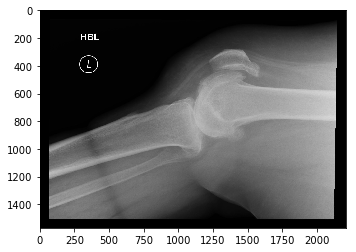

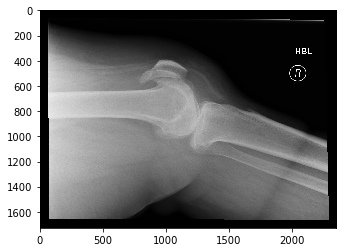

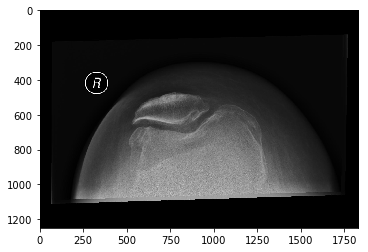

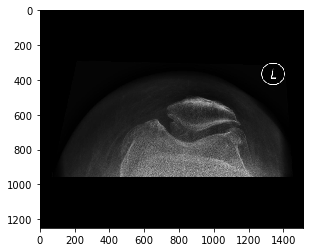

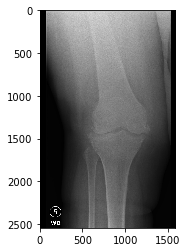

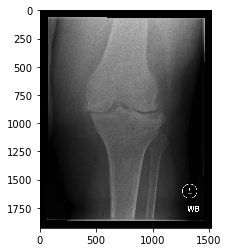

In [133]:
# Sample some predictions
for cnn_features, sentence, impath in random.sample(test_exams,1):
    print impath
    prediction = predict(cnn_features)
    plt.figure()
    for image in os.listdir(dir+'data/Images/'+impath):
        if image.endswith('.jpg'):
            plt.figure()
            im = plt.imread(dir+'data/Images/'+impath + '/' + image)
            plt.imshow(im)
    print "Predicted: " + " ".join(prediction) + "\n Original: " + ' '.join(sentence)
    for n in range(4):
        score = modified_precision([sentence], prediction, n+1)
        print 'BLEU{} score: {}'.format(n+1, float(score))

In [82]:
scores = []
exams = []
for cnn_features, sentence, impath in test_exams:
    prediction = predict(cnn_features)
    #print "Predicted: " + " ".join(prediction) + "\n Original: " + ' '.join(sentence)
    score = modified_precision([sentence], prediction, 1)
    #print 'BLEU1 score', float(score)
    exams.append(['Predicted: '+' '.join(prediction), 'Original: '+' '.join(sentence), impath])
    scores.append(float(score))
    
print max(scores)
max_index = scores.index(max(scores))
print exams[max_index]

0.875
[u'Predicted: joint spaces articular surfaces appear preserved bilaterally .', u'Original: b . joint spaces articular surfaces appear preserved . significant degenerative erosive change seen .', 'RJ109663984']


In [128]:
for cnn_features, sentence, impath in test_exams:
    if impath == exams[max_index][2]:
        #prediction = predict(cnn_features)
        prediction = ['joint', 'space', 'narrowing', 'medial', 'compartments', 'bilaterally', '.']
        print "Predicted: " + " ".join(prediction) + "\n Original: " + ' '.join(sentence)
        score = modified_precision([sentence], prediction, 1)
        print 'BLEU1 score', float(score)

Predicted: joint space narrowing medial compartments bilaterally .
 Original: b . joint spaces articular surfaces appear preserved . significant degenerative erosive change seen .
BLEU1 score 0.285714285714


In [83]:
all_test_scores = []
originals = []
predictions = []
for cnn_features, sentence, impath in test_exams:
    if len(sentence) > 1:
        prediction = predict(cnn_features)
        
        #prediction_en = [word.encode('utf-8') for word in prediction]
        #sentence_en = [word.encode('utf-8') for word in sentence]
        
        predictions.append(prediction)
        originals.append(sentence)
        
        scores = []
        for n_ in range(4):
            score = modified_precision([sentence], prediction, n=n_+1)
            scores.append(float(score))
        #print 'Predicted: ', ' '.join(predictions)
        #print 'Original: ', ' '.join(sentence)
        #print 'Scores: ', scores
        all_test_scores.append(scores)

In [84]:
all_test_scores = np.asarray(all_test_scores)

for n in range(4):
    print 'Average BLEU{} score: {}'.format(n+1, np.mean(all_test_scores[:,n]))
    print 'STD: ', np.std(all_test_scores[:,n])

Average BLEU1 score: 0.376042195181
STD:  0.193049315191
Average BLEU2 score: 0.0732629515325
STD:  0.0960437903575
Average BLEU3 score: 0.02097487249
STD:  0.0401638527748
Average BLEU4 score: 0.00283267457181
STD:  0.0111811064608


## METEOR

In [140]:
print len(originals), len(predictions)
print originals[0]
#print ''
#print predictions[1]

f1 = open('meteor-1.5/maxpool_bbox_predictions_tr.txt', 'w')
for item in predictions:
    f1.write("%s\n" % item)
    
f2 = open('meteor-1.5/maxpool_bbox_originals_tr.txt', 'w')
for item in originals:
    f2.write("%s\n" % item)

2080 2080
[u'bilateral', u'mild', u'genu', u'deformity', u'.', u'.', u'tibial', u'left', u'tkr', u'appears', u'.']
